In [1]:
# RUN THIS LINE ONLY ONCE !!!
import sys
import os
os.chdir('../')
sys.path.append(os.getcwd())

In [2]:
from utils import get_dataset, validate
from learner import Learner
from schedulers import CyclicLRDecay
import random
import torch
import torch.nn as nn
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %H:%M:%S')  

In [4]:
dataset, emb_weights = get_dataset()
dataset.fields['review'].include_lengths = True

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

06/01/2020 23:16:35 INFO : Downloading data
06/01/2020 23:16:41 INFO : Downloading GloVe word vectors
06/01/2020 23:16:41 INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt
06/01/2020 23:16:47 INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt


In [5]:
class Baseline_model(nn.Module):
    """
        Basic baseline model based on a bag of embeddings.

        Args:
            vocab_size - int; size of the dataset vocabulary .
            embed_dim - int; size of the embedding vectors.
            embed_vecs - tensor; pretrained word embeddings (optional).
    """

    def __init__(self, embed_vecs):
        super().__init__()
        self.embed_dim = embed_vecs.shape[1]
        self.embedding = nn.EmbeddingBag.from_pretrained(embed_vecs)
        self.head = nn.Linear(self.embed_dim, 2)

    def forward(self, batch):
        batch, lengths = batch

        trimmed_reviews = [review[:length] for review, length in zip(batch, lengths)]
        batch_concat = torch.cat(trimmed_reviews, dim=0)
        offsets = torch.cat([torch.tensor([0]), torch.cumsum(lengths[:-1], dim=0)])

        out = self.embedding(batch_concat, offsets)  # (B x E)
        return self.head(out)

In [19]:
1e-1*0.5**5

0.003125

In [20]:
model = Baseline_model(emb_weights.clone()).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimiser = AdamW(model.parameters(), lr=8e-4, weight_decay=1e-2)
steps_per_cycle = 2*(len(ds_train)//32 + 1)
scheduler = CyclicLRDecay(optimiser, 1e-4, 1e-2, steps_per_cycle, 0.25, gamma_factor=0.65)
learner = Learner(model, loss_fn, optimiser, scheduler, ds_train, ds_val, device)

0.88%

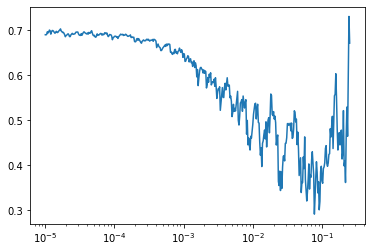

In [9]:
learner.lr_finder(bs=64, lr_range=(1e-5, 1e0))

In [21]:
learner.train(epochs=10, bs=32, grad_clip=(0.2, 0.7))

06/01/2020 23:19:56 INFO : Epoch : 1, batch : 18, train_loss = 0.6834, val_loss = 0.6653, val_accuracy : 0.513, time = 0s
06/01/2020 23:19:57 INFO : Epoch : 1, batch : 36, train_loss = 0.6185, val_loss = 0.5968, val_accuracy : 0.653, time = 0s
06/01/2020 23:19:57 INFO : Epoch : 1, batch : 54, train_loss = 0.5577, val_loss = 0.5352, val_accuracy : 0.763, time = 0s
06/01/2020 23:19:57 INFO : Epoch : 1, batch : 72, train_loss = 0.5163, val_loss = 0.5141, val_accuracy : 0.773, time = 0s
06/01/2020 23:19:57 INFO : Epoch : 2, batch : 18, train_loss = 0.4775, val_loss = 0.4974, val_accuracy : 0.757, time = 0s
06/01/2020 23:19:57 INFO : Epoch : 2, batch : 36, train_loss = 0.4461, val_loss = 0.4924, val_accuracy : 0.783, time = 0s
06/01/2020 23:19:57 INFO : Epoch : 2, batch : 54, train_loss = 0.4633, val_loss = 0.4861, val_accuracy : 0.763, time = 0s
06/01/2020 23:19:57 INFO : Epoch : 2, batch : 72, train_loss = 0.4744, val_loss = 0.4831, val_accuracy : 0.773, time = 0s
06/01/2020 23:19:57 INFO

In [22]:
model.embedding.weight.requires_grad_(True);
learner.train(epochs=8, bs=32, grad_clip=(0.2, 0.7))

06/01/2020 23:20:03 INFO : Epoch : 1, batch : 18, train_loss = 0.3965, val_loss = 0.4410, val_accuracy : 0.793, time = 1s
06/01/2020 23:20:04 INFO : Epoch : 1, batch : 36, train_loss = 0.3632, val_loss = 0.4322, val_accuracy : 0.810, time = 1s
06/01/2020 23:20:04 INFO : Epoch : 1, batch : 54, train_loss = 0.3920, val_loss = 0.4266, val_accuracy : 0.810, time = 2s
06/01/2020 23:20:05 INFO : Epoch : 1, batch : 72, train_loss = 0.3838, val_loss = 0.4165, val_accuracy : 0.813, time = 2s
06/01/2020 23:20:05 INFO : Epoch : 2, batch : 18, train_loss = 0.3021, val_loss = 0.4106, val_accuracy : 0.837, time = 3s
06/01/2020 23:20:06 INFO : Epoch : 2, batch : 36, train_loss = 0.3171, val_loss = 0.4044, val_accuracy : 0.837, time = 3s
06/01/2020 23:20:06 INFO : Epoch : 2, batch : 54, train_loss = 0.3125, val_loss = 0.4003, val_accuracy : 0.843, time = 4s
06/01/2020 23:20:07 INFO : Epoch : 2, batch : 72, train_loss = 0.3354, val_loss = 0.3964, val_accuracy : 0.843, time = 4s
06/01/2020 23:20:07 INFO

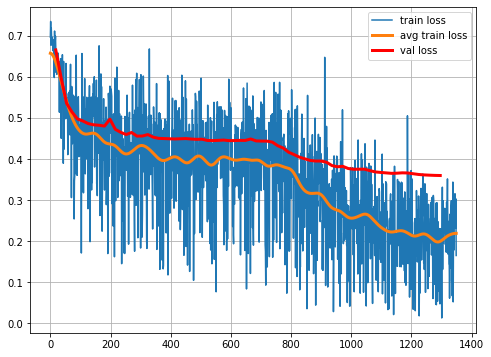

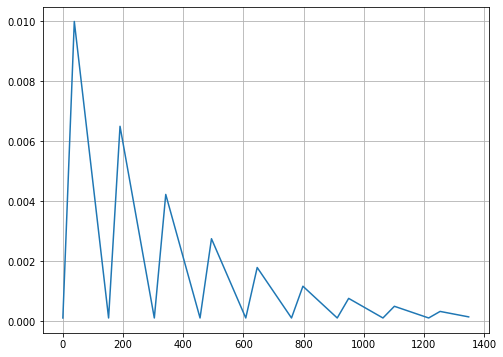

In [23]:
learner.recorder.plot_losses(show_lr=True)

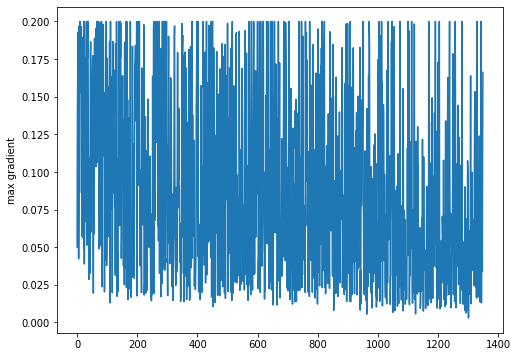

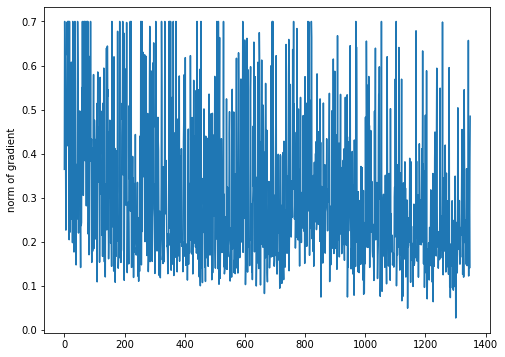

In [24]:
learner.recorder.plot_grads()

In [25]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.32871, test accuracy : 0.870


In [26]:
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/model_baseline.pt')